In [1]:
import pandas as pd
from pathlib import Path
import os
from glob import glob

def mean_reciprocal_rank(rankings: list[list[int]]) -> float:
    """
    Args:
        rankings: A list of queries, each containing a list where
                  1 = relevant, 0 = not relevant (ordered by predicted rank).
    Returns:
        MRR score
    """
    reciprocal_ranks = []
    for ranked_list in rankings:
        try:
            rank = ranked_list.index(1) + 1  # first relevant item
            reciprocal_ranks.append(1 / rank)
        except ValueError:
            reciprocal_ranks.append(0.0)  # no relevant item found
    return sum(reciprocal_ranks) / len(rankings)

import math

def dcg(relevance: list[int], k: int) -> float:
    return sum((2**rel - 1) / math.log2(i + 2) for i, rel in enumerate(relevance[:k]))

def ndcg(relevance: list[int], k: int) -> float:
    ideal = sorted(relevance, reverse=True)
    idcg = dcg(ideal, k)
    return dcg(relevance, k) / idcg if idcg > 0 else 0.0

def average_ndcg(relevance_lists: list[list[int]], k: int) -> float:
    scores = [ndcg(rel, k) for rel in relevance_lists]
    return sum(scores) / len(scores)

def recall_at_k(responses: list, references: list) -> float:
    retrieved = set(responses)
    relevant = set(references)
    intersection_count = len(retrieved.intersection(relevant))
    return intersection_count / len(relevant) if len(relevant) > 0 else 0.0

def average_recall_at_k(batch_responses: list[list], batch_references: list[list]) -> float:
    """
    Args:
        batch_responses: List of lists of responses (one per query)
        batch_references: List of lists of references (one per query)
    Returns:
        Average Recall@k over all queries
    """
    assert len(batch_responses) == len(batch_references), "Mismatch in number of queries"
    
    recalls = []
    for responses, references in zip(batch_responses, batch_references):
        recalls.append(recall_at_k(responses, references))
    return sum(recalls) / len(recalls)


In [99]:
df = pd.read_csv("/home/hawau/Latin-Document-Search-Engine/target_best1k_data/PhilBerta_index/Latin_benchmark_best_targets.txt", sep="\t")

df.shape

(100, 256)

In [100]:
targets = [f"Target #{i}" for i in range(1, 6)]
top_k = [f"best #{i}" for i in range(0, 5)]
batch_responses = df[targets].values.tolist()
batch_references = df[top_k].values.tolist()

avg_recall = average_recall_at_k(batch_responses, batch_references)
print(f"Average Recall@5: {avg_recall:.4f}")

Average Recall@5: 0.3382


In [87]:
targets = [f"Target #{i}" for i in range(1, 6)]
top_k = [f"best #{i}" for i in range(0, 5)]

def check_matches(row):
    target_match = []
    for i in range(5):
        if row[targets[i]] in row[top_k].tolist():
            target_match.append(1)
        else:
            target_match.append(0)
    return target_match
df['target_match'] = df.apply(check_matches, axis=1)
df.head(2)

,Query,Target #1,Target #2,Target #3,Target #4,Target #5,best #0,best #1,best #2,best #3,...,best #241,best #242,best #243,best #244,best #245,best #246,best #247,best #248,best #249,target_match
0,Dicitur mulieres sapientiores esse viris.,"Antiqui, qui de sapientia per homines notionem...","De mulieribus et viris quaerebant philosophi, ...","Num putas mulieres, quibus natura sollertem et...","Et tunc episcopus Alexandrinus, qui veritatem ...","Feminae et viri, qui mutuo mentem possident et...","xxu, mulier si primatum habeat, contraria est ...","apostolum non dicere, ut publice uiros anno ur...","apostolum non dicere, ut publice uiros anno ur...","apostolum non dicere, ut publice uiros anno ur...",...,sic te deus adiuuet! quod mulieres debent esse...,cuius quidem rei rationem inducens macrobius t...,iii. in primordio siquidem fidei erant multae ...,caput xix. in epistola ad bonifacium causidicu...,caput xix. in epistola ad bonifacium causidicu...,caput xix. in epistola ad bonifacium causidicu...,"Notum est mulieres Aethiopiae, cutem habentes ...",ideo dicit salomo ne mulier diligens corona e...,ideo dicit salomo ne mulier diligens corona e...,"[0, 0, 0, 0, 0]"
1,"Dicitur habitatio hominum non solum in terra, ...",Multis enim videtur quod habitatio hominum ad ...,"Secundum traditiones, humanitas non solum ex t...","In mutatione visibilis et invisibilis, sunt qu...",In rationibus cosmologicis dicitur viros eximi...,Non omnes creaturae anthropomorphae terram cal...,"sic nostra conuersatio dicitur esse in caelis,...","sic nostra conuersatio dicitur esse in caelis,...","sic nostra conuersatio dicitur esse in caelis,...","sic nostra conuersatio dicitur esse in caelis,...",...,"id est, in corruptum, solidum ac uigens persti...","id est, in corruptum, solidum ac uigens persti...","id est, oro contra prauos eorum conatus. orbis...","id est, oro contra prauos eorum conatus. orbis...","id est, oro contra prauos eorum conatus. orbis...","id est, oro contra prauos eorum conatus. orbis...","dicitur deus creasse caelum et terram, tota mo...","dicitur deus creasse caelum et terram, tota mo...","dicitur deus creasse caelum et terram, tota mo...","[0, 0, 0, 0, 0]"


In [88]:
k = 5
avg_score = average_ndcg(df['target_match'].tolist(), k)
print(f"Average NDCG@{k}: {avg_score:.4f}")

Average NDCG@5: 0.8920


In [89]:
mrr = mean_reciprocal_rank(df['target_match'].tolist())
print(f"Mean Reciprocal Rank: {mrr:.4f}")

Mean Reciprocal Rank: 0.8967


In [105]:
df_lata = pd.read_csv("/home/hawau/Latin-Document-Search-Engine/target_best1k_data/PhilBerta_index/_outputs_bowphs_LaBerta/Latin_benchmark_best_cosine_similarities.txt", sep="\t")
df_lata.shape

(100, 256)

In [106]:
top_k = [f"best #{i}" for i in range(0, 250)]
top5_columns_per_row = df_lata[top_k].apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
# top5_columns_per_row

In [107]:
top_5 = [f"best #{i}" for i in range(0, 5)]
for index,row in enumerate(top5_columns_per_row):
    df_lata.loc[index,top_5] = df.loc[index,row].to_list()


/tmp/ipykernel_2519374/550872595.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ii,; sic erat scriptum intelligendum est, ut in uiros illis sit doctrina sublata caeterum adolescentulas doceant, quasi filias suas, primum castitatem; quia aduersus hanc magis in aetate florenti pugnat inimicus, et uirtus eius contra feminas in umbilico uentris est. uers.,.adolescentulas    cod.,  adulescentulas et adhulescentulas, ut uiros suos diligant, filios ament. prudentes, sobrias, castas, domus curam habentes, benignas, subditas uiris suis, ut non blasphemetur uerbum dei.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_lata.loc[index,top_5] = df.loc[index,row].to_list()
/tmp/ipykernel_2519374/550872595.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ii,; sic erat scriptum intellig

In [ ]:
df_lata.head()

In [108]:
batch_responses = df[targets].values.tolist()
batch_references = df_lata[top_5].values.tolist()

avg_recall = average_recall_at_k(batch_responses, batch_references)
print(f"Average Recall@5: {avg_recall:.4f}")

Average Recall@5: 0.4755


In [66]:
targets = [f"Target #{i}" for i in range(1, 6)]
top_k = [f"best #{i}" for i in range(0, 5)]
batch_responses = df[targets].values.tolist()
batch_references = df[top_k].values.tolist()

avg_recall = average_recall_at_k(batch_responses, batch_references)
print(f"Average Recall@5: {avg_recall:.4f}")

Average Recall@5: 0.3497


In [ ]:
faiss_results = list(glob("/home/hawau/Latin-Document-Search-Engine/data/*/Latin_benchmark_best_faiss_distances.txt"))


for i in faiss_results:
    print(Path(i).parent.name)
    print("--------------------------------------------------")

    df = pd.read_csv(i, sep="\t")
    targets = [f"Target #{i}" for i in range(1, 6)]
    top_k = [f"best #{i}" for i in range(0, 1000)]


    # top_k = [f"best #{i}" for i in range(0, 5)] + targets

    # top5_columns_per_row = df[top_k].apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
    # print("Top 5 Columns for Rows 1 - 5:")
    # print(top5_columns_per_row)
    # print("Target Metrics:")
    # print(df[targets].mean(axis=1).describe())

    print("----------------")

    print("Top K Metrics:")
    print(df[top_k].mean(axis=1).describe())

### Ranking Relevance 

In [ ]:
cosine_results = list(glob("/home/hawau/Latin-Document-Search-Engine/data/*/Latin_benchmark_best_cosine_similarities.txt"))


for i in cosine_results:
    print(Path(i).parent.name)
    print("--------------------------------------------------")

    df = pd.read_csv(i, sep="\t")
    targets = [f"Target #{i}" for i in range(1, 6)]
    # top_k = [f"best #{i}" for i in range(0, 1000)]


    top_k = [f"best #{i}" for i in range(0, 1000)] + targets

    top5_columns_per_row = df[top_k].apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
    print("Top 5 Columns for Rows 1 - 5:")
    print(top5_columns_per_row)
    # # print("Target Metrics:")
    # # print(df[targets].mean(axis=1).describe())

    # print("----------------")

    # print("Top K Metrics:")
    # print(df[top_k].mean(axis=1).describe())

In [24]:
r_rank = pd.DataFrame(top5_columns_per_row)
r_rank['scores'] = r_rank[0].apply(lambda xx: [1 if x.split(" ")[0] == "Target" else 0 for x in xx])
r_rank

,0,scores
0,"[best #4, Target #3, best #3, Target #2, best #2]","[0, 1, 0, 1, 0]"
1,"[Target #4, best #1, Target #5, best #0, Targe...","[1, 0, 1, 0, 1]"
2,"[best #0, Target #1, best #2, best #1, Target #2]","[0, 1, 0, 0, 1]"
3,"[best #3, Target #3, best #1, best #0, best #2]","[0, 1, 0, 0, 0]"
4,"[best #2, Target #1, best #4, best #1, Target #4]","[0, 1, 0, 0, 1]"
...,...,...
95,"[best #1, Target #5, best #0, Target #1, best #2]","[0, 1, 0, 1, 0]"
96,"[best #0, Target #4, best #3, Target #1, best #1]","[0, 1, 0, 1, 0]"
97,"[best #0, Target #1, best #3, Target #5, best #1]","[0, 1, 0, 1, 0]"
98,"[best #1, Target #1, best #3, Target #4, best #4]","[0, 1, 0, 1, 0]"


In [11]:
def mean_reciprocal_rank(rankings: list[list[int]]) -> float:
    """
    Args:
        rankings: A list of queries, each containing a list where
                  1 = relevant, 0 = not relevant (ordered by predicted rank).
    Returns:
        MRR score
    """
    reciprocal_ranks = []
    for ranked_list in rankings:
        try:
            rank = ranked_list.index(1) + 1  # first relevant item
            reciprocal_ranks.append(1 / rank)
        except ValueError:
            reciprocal_ranks.append(0.0)  # no relevant item found
    return sum(reciprocal_ranks) / len(rankings)

In [34]:
mrr = mean_reciprocal_rank(r_rank['scores'].tolist())
print(f"Mean Reciprocal Rank: {mrr:.4f}")

Mean Reciprocal Rank: 0.8407


#### NDCG@k for multiple queries

In [35]:
import math

def dcg(relevance: list[int], k: int) -> float:
    return sum((2**rel - 1) / math.log2(i + 2) for i, rel in enumerate(relevance[:k]))

def ndcg(relevance: list[int], k: int) -> float:
    ideal = sorted(relevance, reverse=True)
    idcg = dcg(ideal, k)
    return dcg(relevance, k) / idcg if idcg > 0 else 0.0

def average_ndcg(relevance_lists: list[list[int]], k: int) -> float:
    scores = [ndcg(rel, k) for rel in relevance_lists]
    return sum(scores) / len(scores)


In [36]:
queries_relevance = [
    [0, 0, 1, 1, 1],   # Query x
    [1, 0, 1, 0, 1],   # Query y
    [1, 0, 0, 0, 0],   # Query z
]

k = 5
avg_score = average_ndcg(queries_relevance, k)
print(f"Average NDCG@{k}: {avg_score:.4f}")

Average NDCG@5: 0.8346


In [37]:
k = 5
avg_score = average_ndcg(r_rank['scores'].tolist(), k)
print(f"Average NDCG@{k}: {avg_score:.4f}")

Average NDCG@5: 0.8440


In [8]:
cosine_results = list(glob("/home/hawau/Latin-Document-Search-Engine/target_best1k_data/LaBerta_index/*/Latin_benchmark_best_cosine_similarities.txt"))
k=5

for i in cosine_results:
    print("--------------------------------------------------")
    print(Path(i).parent.name)
    print("--------------------------------------------------")

    df = pd.read_csv(i, sep="\t")
    targets = [f"Target #{i}" for i in range(1, 6)]
    top_k = [f"best #{i}" for i in range(0, 5)] + targets

    top5_columns_per_row = df[top_k].apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

    r_rank = pd.DataFrame(top5_columns_per_row)
    r_rank['scores'] = r_rank[0].apply(lambda xx: [1 if x.split(" ")[0] == "Target" else 0 for x in xx])

    avg_score = average_ndcg(r_rank['scores'].tolist(), k)
    print(f"Average NDCG@{k}: {avg_score:.4f}")

    mrr = mean_reciprocal_rank(r_rank['scores'].tolist())
    print(f"Mean Reciprocal Rank: {mrr:.4f}")

    print("")


--------------------------------------------------
_outputs_bowphs_LaBerta
--------------------------------------------------
Average NDCG@5: 0.6017
Mean Reciprocal Rank: 0.4617

--------------------------------------------------
_outputs_bowphs_LaTa
--------------------------------------------------
Average NDCG@5: 0.6773
Mean Reciprocal Rank: 0.5308

--------------------------------------------------
_outputs_bowphs_PhilBerta
--------------------------------------------------
Average NDCG@5: 0.7101
Mean Reciprocal Rank: 0.5867



### Visualizations

In [39]:
queries = pd.read_csv("/home/hawau/Greek-Document-Search-Engine/data/Greek_benchmark.txt", sep="\t")['Query'].tolist()[:5]
queries

['Λέγεται ὅτι αἱ γυναῖκες σοφώτεραι εἶναι τῶν ἀνδρῶν.',
 'Ἀνθρώπων ἡ κατοικία οὐ μόνον ἐν γῇ, ἀλλὰ καὶ ἐν τοῖς ἀπείροις οὐρανοῖς εἶναι λέγεται.',
 'Ἐν τῷ νότῳ τῆς Ἀντιόχειας, οἱ πρεσβύτεροι τρέφονται ὑπὸ ξύλων καὶ ἰών.',
 ' οἱ ὄνοι εἰσὶ τὰ ζῷα ἐναργέστατα πάντων',
 'οἱ ἀπόστολοι ἐφόνευσαν πολλοὺς παῖδας.']

In [64]:
df = pd.read_csv("/home/hawau/Greek-Document-Search-Engine/data/Greek_benchmark_best_targets.txt", sep="\t")
top_k = [f"best #{i}" for i in range(0, 5)]
top_k

['best #0', 'best #1', 'best #2', 'best #3', 'best #4']

In [65]:
queries = df[top_k].iloc[1].tolist()

queries

['Σωζομένων γὰρ τῶν ἐπὶ γῆς, χαρὰ ἔσται ἐν οὐρανοῖς, συγχαιρόντων τῶν ἐν τοῖς ὑψίστοις οἰκούντων ἀγγέλων τῇ τῶν ἀνθρώ πων σωτηρίᾳ.',
 'Οὐκ ἐν τῷ οὐρανῷ μόνον, ἀλλὰ καὶ ἐν τῇ γῇ.',
 'Οὐ μόνον δὲ ἡ γῆ καὶ τὸ πλήρωμα αὐτῆς, ἀλλὰ καὶ ἡ οἰκουμένη. Ἐν ἐρήμῳ κατοικεῖ ὁ ἁμαρτωλὸς, ὁ δὲ ἐν τῇ Ἐκκλησίᾳ τυγ χάνων τῇ πεπληρωμένῃ τῆς ἁγίας Τριάδος, οὗτος κατοικεῖ τὴν οἰκουμένην, ἥτις ἐστὶν ἡ Ἐκκλησία, ἐπὶ θαλασσῶν τῶν πειρασμῶν ὑπὸ Κυρίου θεμε λιουμένη, καὶ ἐν αὐτοῖς νικῶσα, ἵνα μετὰ τοῦτο ποτιζομένη ἐπὶ ποταμοῦ ἑτοιμασθῇ.',
 "Εἰ δὲ σπανίως μὲν εὑρίσκοιντο ἐπὶ γῆς τοιοῦτοι, ἐν δὲ τῇ κατ' οὐρανὸν χρηματιζούσῃ Θεοῦ πόλει πληθύει τὸ τοῦ Θεοῦ οἰκητήριον, ἐν ἀγγέλοις, καὶ ἀρχ αγγέλοις, καὶ θείαις δυνάμεσι, καὶ πνεύμασιν ἁγίοις· εἰκότως τὸν τόπον τοῦ Θεοῦ παρ' ἐκείνοις εἴποι ἄν τις, κἀκείνην εἶναι τὴν εἰρήνην ἀληθῶς Σαλὴμ ἐνταῦθα κατὰ τὴν Ἑβραϊκὴν φωνὴν ὠνομασμένην.",
 'Σευηριανός φησιν, ἐν οὐρανοῖς, φησιν, ἡ τῶν δικαίων δια γωγή· ἐπὶ γῆς δὲ ἡ πάντων ἀνθρώπων.']

In [66]:
import torch
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, BertTokenizer, BertForMaskedLM
device = "cuda:3"



model_name = "bowphs/GreBerta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

queries_GreBerta = []

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_GreBerta.append(a[0])



queries_LaBerta = []
model_name = "bowphs/LaBerta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_LaBerta.append(a[0])


queries_PhilBerta = []
model_name = "bowphs/PhilBerta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_PhilBerta.append(a[0])


queries_GreTa = []
model_name = "bowphs/GreTa"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).get_encoder().to(device)

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_GreTa.append(a[0])



model_name = "bowphs/SPhilBerta"
model = SentenceTransformer(model_name).to(device)
queries_SPhilBerta = []

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    with torch.no_grad():
        a[0] = model.encode(text, convert_to_tensor=True).squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    
    queries_SPhilBerta.append(a[0])


queries_PhilTa = []
model_name = "bowphs/PhilTa"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).get_encoder().to(device)

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_PhilTa.append(a[0])


queries_logionBertBase = []
tokenizer = BertTokenizer.from_pretrained("princeton-logion/logion-bert-base")
model = BertForMaskedLM.from_pretrained("princeton-logion/logion-bert-base")

for text in queries:
    a = np.zeros((1, 768)).astype(np.float32)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    a[0] = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
    faiss.normalize_L2(a)
    queries_logionBertBase.append(a[0])

In [67]:

# Store them in a dictionary for convenience
models = {
    "GreBerta": queries_GreBerta,
    "LaBert": queries_LaBerta,
    "PhilBerta": queries_PhilBerta,
    "GreTa" : queries_GreTa,
    "SPhilBerta": queries_SPhilBerta,
    "PhilTa": queries_PhilTa,
    "logion-bert-base": queries_logionBertBase,
}


In [68]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize an empty similarity matrix
model_names = list(models.keys())
n = len(model_names)
similarity_matrix = np.zeros((n, n))

# Compute average pairwise cosine similarity between model query embeddings
for i in range(n):
    for j in range(n):
        sim = cosine_similarity(models[model_names[i]], models[model_names[j]])
        similarity_matrix[i, j] = np.mean(sim)


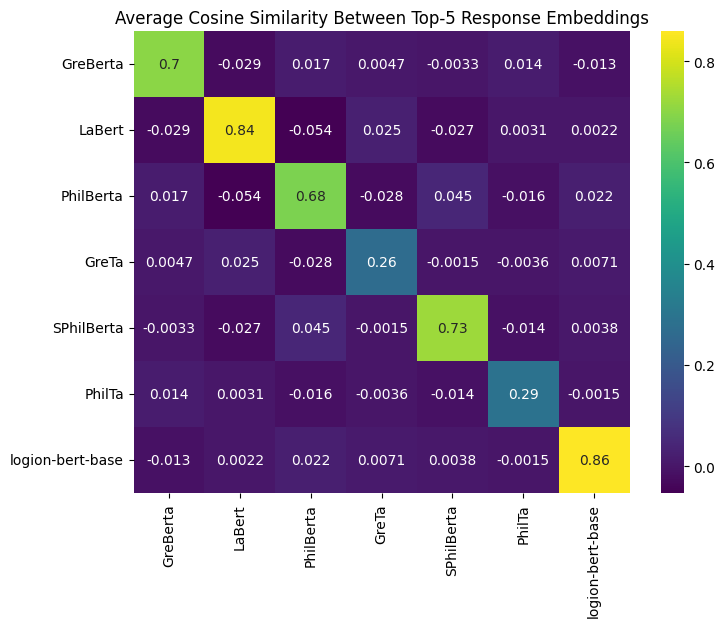

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, xticklabels=model_names, yticklabels=model_names, annot=True, cmap="viridis")
plt.title("Average Cosine Similarity Between Top-5 Response Embeddings")
plt.show()


### Response vs. Target response

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, BertTokenizer, BertForMaskedLM
import seaborn as sns
import matplotlib.pyplot as plt
import torch
device = "cuda:3"

# Sample data
ground_truth =pd.read_csv("/home/hawau/Latin-Document-Search-Engine/data/Latin_benchmark.txt", sep="\t")['Query'].tolist()[:5]

df = pd.read_csv("/home/hawau/Latin-Document-Search-Engine/data/Latin_benchmark_best_targets.txt", sep="\t")
top_k = [f"best #{i}" for i in range(0, 10)]

targets = [f"Target #{i}" for i in range(1, 6)]

ground_truth = df[targets].iloc[1].tolist()

model_responses = df[top_k].iloc[1].tolist()

model_name = "bowphs/LaBerta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

In [18]:
inputs = tokenizer(ground_truth, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
gt_embeddings = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)
gt_embeddings.shape

(5, 768)

In [20]:
inputs = tokenizer(model_responses, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
resp_embeddings = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)

In [21]:


# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(resp_embeddings, gt_embeddings)

# Get best match similarity for each response (max over 5 GTs)
best_similarities = np.max(similarity_matrix, axis=1)

# Print top-10 responses with their best similarity scores
for i, sim in enumerate(best_similarities):
    print(f"Response {i+1}: '{model_responses[i]}' → Best similarity: {sim:.3f}")


Response 1: 'media autem bona et mala in medio, hoc est in hoc mundo mixta sunt. dicitur infernus inferior esse locus in imo terrae, damnandorum poenis praeparatus. de quo tamen omnino certum non est, in qua parte eius, id est utrum intra concauitatem illius, sub uerbo extrinsecus in aliqua regione ambitus ipsius dispositus sit, quamuis tamen uerisimilius uideatur infra terram quasi carcerem quemdam, et uel ut ergastulum tenebrarum collocatur.' → Best similarity: 0.573
Response 2: 'et sic, cum isti quatuor caeli tribus superioribus connumerantur, fiunt in uniuerso, secundum rabanum, septem caeli corporei. tertio dicitur caelum metaphorice. et sic erat scriptum quandoque ipsa sancta trinitas dicitur caelum, propter eius spiritualem sublimitatem et lucem.' → Best similarity: 0.614
Response 3: 'et sic, cum isti quatuor caeli tribus superioribus connumerantur, fiunt in uniuerso, secundum rabanum, septem caeli corporei. tertio dicitur caelum metaphorice. et sic erat scriptum quandoque ipsa 

In [22]:
similarity_matrix

array([[0.57293594, 0.47541508, 0.5352069 , 0.47593778, 0.5477916 ],
       [0.49596155, 0.5815882 , 0.53767455, 0.44629222, 0.6136282 ],
       [0.49596155, 0.5815882 , 0.53767455, 0.44629222, 0.6136282 ],
       [0.49596155, 0.5815882 , 0.53767455, 0.44629222, 0.6136282 ],
       [0.49596155, 0.5815882 , 0.53767455, 0.44629222, 0.6136282 ],
       [0.40892842, 0.46855286, 0.5023774 , 0.4266119 , 0.51134574],
       [0.40892842, 0.46855286, 0.5023774 , 0.4266119 , 0.51134574],
       [0.40892842, 0.46855286, 0.5023774 , 0.4266119 , 0.51134574],
       [0.40892842, 0.46855286, 0.5023774 , 0.4266119 , 0.51134574],
       [0.40892842, 0.46855286, 0.5023774 , 0.4266119 , 0.51134574]],
      dtype=float32)

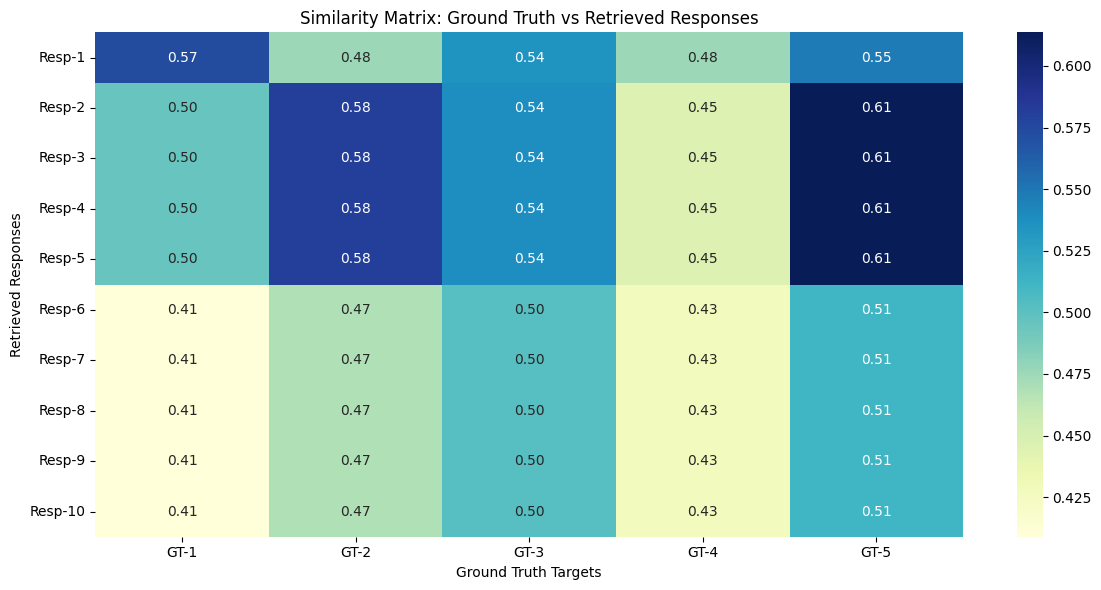

In [23]:
groundtruth_labels = [f"GT-{i}" for i in range(1, 6)]
response_labels = [f"Resp-{i}" for i in range(1, 11)]

df_sim = pd.DataFrame(similarity_matrix, columns=groundtruth_labels, index=response_labels)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_sim, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Similarity Matrix: Ground Truth vs Retrieved Responses")
plt.ylabel("Retrieved Responses")
plt.xlabel("Ground Truth Targets")
plt.tight_layout()
plt.show()

## T-SNE for embeddings

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = "cuda:3"
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer, BertForMaskedLM

query =pd.read_csv("/home/hawau/Latin-Document-Search-Engine/data/Latin_benchmark.txt", sep="\t")['Query'].tolist()


gt_response = pd.read_csv("/home/hawau/Latin-Document-Search-Engine/data/Latin_benchmark_best_targets.txt", sep="\t")["Target #1"].tolist()
# [50:]

pred_response = pd.read_csv("/home/hawau/Latin-Document-Search-Engine/data/Latin_benchmark_best_targets.txt", sep="\t")["best #1"].tolist()
# [50:]

all_responses = query + gt_response + pred_response
model_name = "bowphs/LaBerta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)

# tokenizer = BertTokenizer.from_pretrained("princeton-logion/logion-bert-base")
# model = BertForMaskedLM.from_pretrained("princeton-logion/logion-bert-base").to(device)

inputs = tokenizer(all_responses, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

embeddings = outputs['hidden_states'][-1][:,0,:].squeeze().cpu().numpy().astype(np.float32)

num_samples = len(query)

type_labels = ["query"] * num_samples + ["gt_target"] * num_samples + ["model_response"] * num_samples # Optional: group labels for coloring
labels = [f"Row-{i}" for i in range(num_samples)] * 3

type_to_marker = {'query': 'o', 'gt_target': 'x', 'model_response': '^'}


# --- PCA ---
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)

# --- t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


/tmp/ipykernel_806402/1209005429.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


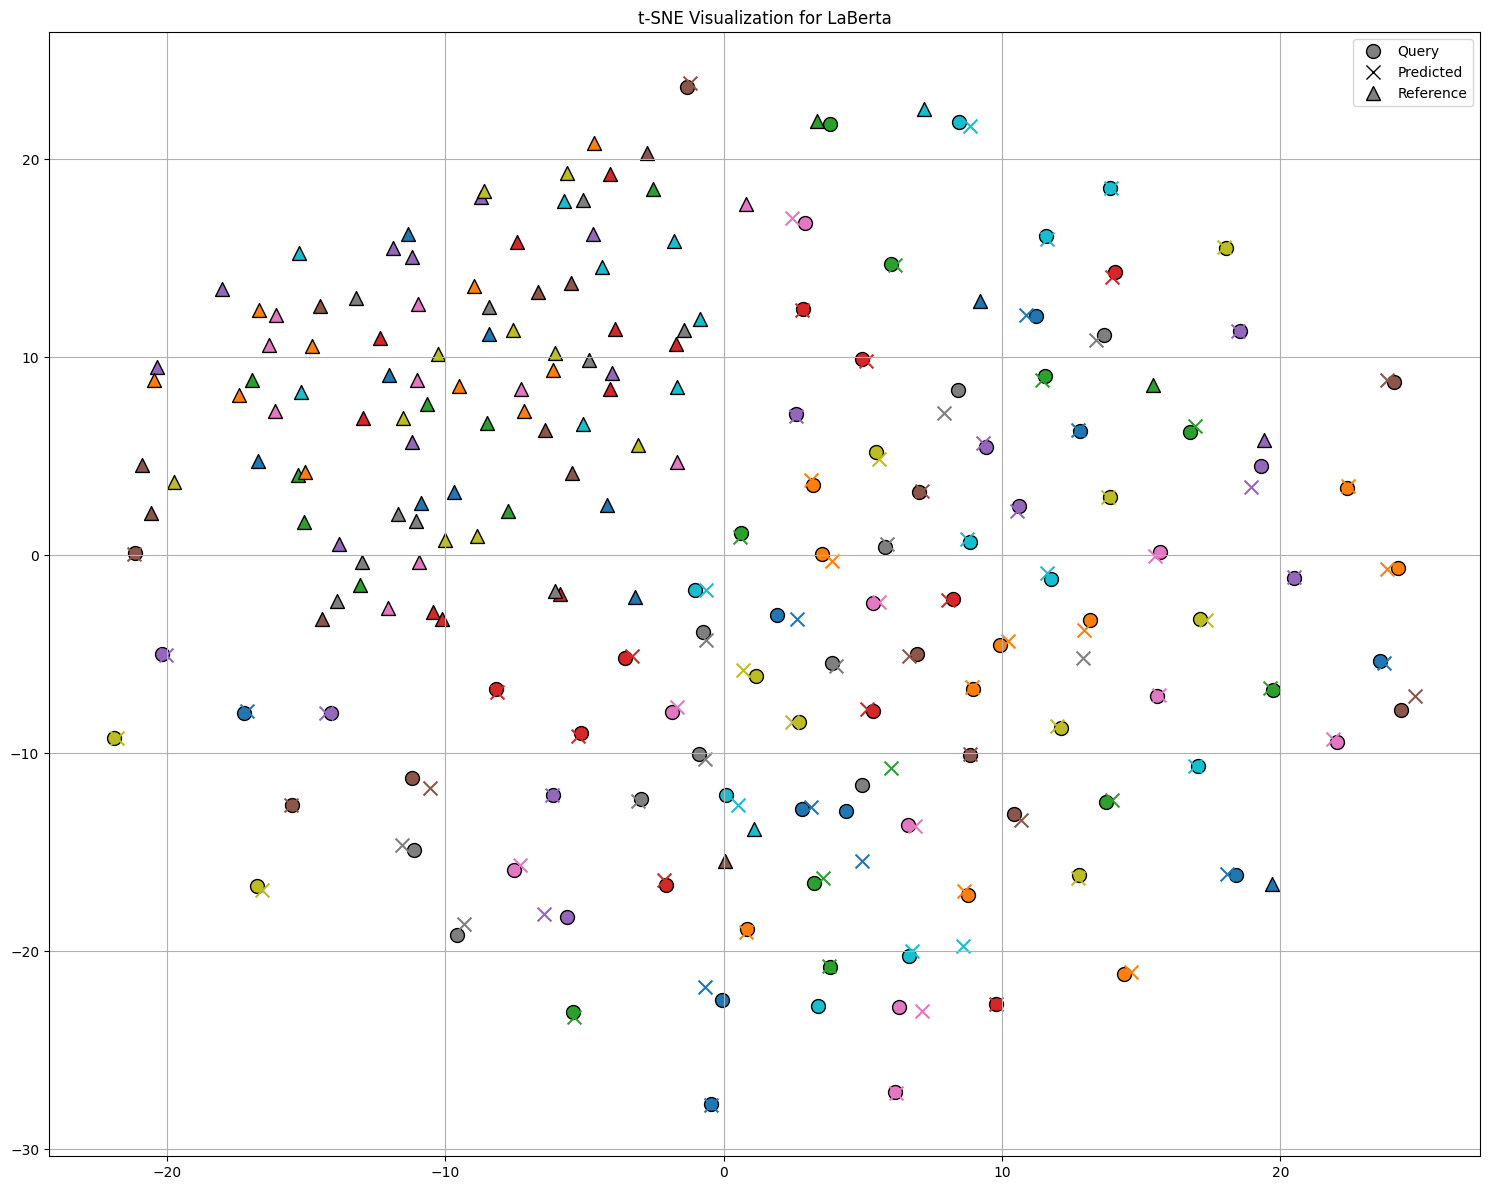

In [26]:
# --- Plotting function ---
def plot_embeddings(emb, title, row_labels=None):
    unique_rows = list(set(row_labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_rows)))
    row_to_color = {row: colors[i] for i, row in enumerate(unique_rows)}
    plt.figure(figsize=(15 ,12))
    for i in range(len(emb)):
        plt.scatter(
            emb[i, 0],
            emb[i, 1],
            marker=type_to_marker[type_labels[i]],
            color=row_to_color[row_labels[i]],
            label=f"{type_labels[i]}-{row_labels[i]}" if i < 3 else None,  # Avoid clutter
            s=100,
            edgecolors='black'
        )

    # Add custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Query', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='x', color='w', label='Predicted', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', label='Reference', markerfacecolor='gray', markersize=10, markeredgecolor='black')
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# --- Visualize ---
# plot_embeddings(emb_pca, "PCA Visualization", labels)
plot_embeddings(emb_tsne, "t-SNE Visualization for LaBerta", labels)